In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import math
import time
from torch.utils.data import Dataset,DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Using " + str(device))

Using cpu


Import data

In [3]:
def load_data(filename):
    with open("fbmerge_" + filename + ".txt") as f:
        content = f.readlines()
    dim = len(content[0].split())
    print("Number of bits is : " + str(dim))
    n = len(content)
    print("Number of samples is : " + str(n))
    data = torch.zeros(n, dim)
    for i in range(n):
        vals = content[i].split()
        for j in range(dim):
            data[i,j] = float(vals[j])
    with open("fermerge_" + filename + ".txt") as f:
        content = f.readlines()
    assert(len(content) == n)
    target = torch.zeros(n)
    for i in range(n):
        target[i] = float(content[i])
    return data, target

dataset_name = "small"
data, target = load_data(dataset_name)
print("Best fer on dataset is {:g}".format(target.min().item()))

Number of bits is : 256
Number of samples is : 77466
Best fer on dataset is 0.000167


Preprocessing data:

In [4]:
def cut_train_val(data, target, prop = 0.8):
    n = data.shape[0]
    n_train = int(float(n) * 0.8)
    return data[:n_train], target[:n_train], data[n_train:], target[n_train:]

x_train, y_train, x_val, y_val = cut_train_val(data, target)

print("Using " + str(x_train.shape[0]) + " samples to train")
print("Using " + str(x_val.shape[0]) + " samples to validate")

mean_x_train = x_train.reshape(-1).mean()
std_x_train = x_train.reshape(-1).std()
keep_indices = torch.where(x_train.std(dim = 0) > 0)[0].numpy()
default_vals = torch.mean(x_train, dim = 0, keepdim = True)

print("Only varying indices are " + str(keep_indices))

def standardize_input(data):
    result = torch.zeros(data.shape[0], len(keep_indices))
    for i in range(data.shape[0]):
        for j in range(len(keep_indices)):
            result[i, j] = (data[i,keep_indices[j]] - mean_x_train) / std_x_train
    return result

def unstandardize_input(data):
    result = default_vals + torch.zeros(data.shape[0], x_train.shape[1])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            result[i, keep_indices[j]] = data[i, j] * std_x_train + mean_x_train
    return result

new_x_train, new_x_val = standardize_input(x_train), standardize_input(x_val)

print(x_train[0])
print(new_x_train[0])
print(unstandardize_input(new_x_train)[0])

mean_log_y_train = torch.log(y_train).mean()
std_log_y_train = torch.log(y_train).std()

def standardize_output(data):
    return (torch.log(data) - mean_log_y_train) / std_log_y_train

def unstandardize_output(data):
    return torch.exp((data * std_log_y_train) + mean_log_y_train)
   
new_y_train, new_y_val = standardize_output(y_train), standardize_output(y_val)

print(y_train[0])
print(new_y_train[0])
print(unstandardize_output(new_y_train)[0])

input_dim = new_x_train.shape[1]

best_fer_dataset = torch.min(new_y_train)
print("best fer logscale: " + str(best_fer_dataset))

Using 61972 samples to train
Using 15494 samples to validate
Only varying indices are [ 47  55  59  60  79  86  89  90  92  99 101 102 105 106 108 113 114 116
 141 142 147 149 150 153 154 156 163 165 166 168 176 195 196 200 208 224]
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,

In [5]:
print(new_y_train)

tensor([-2.0406, -0.6274, -0.0821,  ..., -0.6202, -0.5161,  1.4801])


In [6]:
class SimpleDataset(Dataset):
    def __init__(self, all_data, all_targets):
        super(Dataset, self).__init__()
        self.data = all_data
        self.targets = all_targets

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        return img, target

    def __len__(self) -> int:
        return self.data.shape[0]

train_loader = DataLoader(SimpleDataset(new_x_train, new_y_train), batch_size=32, shuffle = True, num_workers = 4)
test_loader = DataLoader(SimpleDataset(new_x_val, new_y_val), batch_size=32, num_workers = 4)

Defining architectures

In [7]:
class Architecture(nn.Module):
    expansion = 1
    def __init__(self, depth, hidden_layer_size, skip_gaps, dropout = False, bns = False):
        super(Architecture, self).__init__()
        layers = []
        previous_size = input_dim
        for i in range(depth):
            layer = []
            layer.append(nn.Linear(previous_size, 1 if i == depth - 1 else hidden_layer_size, bias = not bns))
            previous_size = 1 if i == depth - 1 else hidden_layer_size
            if bns:
                layer.append(nn.BatchNorm1d(previous_size))
            if dropout and i < depth - 1:
                layer.append(nn.Dropout(0.5))
            if i < depth - 1:
                layer.append(nn.ReLU())
            layers.append(nn.Sequential(*layer))
        self.layers = nn.ModuleList(layers)
        self.skip_gaps = skip_gaps
        self.dropout = dropout
        
    def forward(self, x):
        if self.dropout:
            activations = [torch.nn.functional.dropout(x, 0.5)]
        else:
            activations = [x]
        for i in range(len(self.layers)):
            activations.append(self.layers[i](activations[-1]))
            if i - 1 % self.skip_gaps == 0 and i > self.skip_gaps:
                activations[-1] += activations[-1 - self.skip_gaps]
        return activations[-1].reshape(-1)

In [8]:
def train(model, epochs, mixup, verbose = False):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (batch_idx, (data, target)) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            if mixup:
                lam = random.random()
                index_mixed = torch.randperm(data.shape[0])
                data = lam * data + (1 - lam) * data[index_mixed]
            output = model(data)
            if mixup:
                loss = lam * criterion(output, target) + (1 - lam) * criterion(output, target[index_mixed])
            else:
                loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if verbose:
            print(epoch + 1, epochs, total_loss / (batch_idx+1))

In [9]:
def test(model, loader = test_loader, y_val = y_val, verbose = False):
    model.eval()
    results = []
    criterion = torch.nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for (batch_idx, (data, target)) in enumerate(loader):
            data = data.to(device)
            output = model(data)
            total_loss += criterion(output, target)
            results.append(output)
    if verbose:
        print("Test loss: " + str(total_loss / (batch_idx + 1)))
    results = torch.cat(results, dim = 0).cpu()
    readable_outputs = unstandardize_output(results)
    mean_ratio = 0
    worst_ratio = 0
    for i in range(readable_outputs.shape[0]):
        ratio = max(readable_outputs[i] / y_val[i], y_val[i] / readable_outputs[i])
        mean_ratio += ratio
        worst_ratio = max(worst_ratio, ratio)
    mean_ratio /= readable_outputs.shape[0]
    return mean_ratio, worst_ratio

In [10]:
class Dummy(nn.Module):
    def __init__(self):
        super(Dummy, self).__init__()
        
    def forward(self, x):
        return torch.zeros(x.shape[0])

In [11]:
print(test(Dummy()))

(tensor(1.8603), tensor(16.4132))


In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [13]:
def confidence(scores):
    return np.std(scores) * 1.96 / math.sqrt(len(scores))
    
def stats(depth, hidden_layer_size, skip_gaps, dropout, bns, mixup, max_time = -1, runs = 1):
    start_time = time.time()
    mean_results = []
    worst_results = []
    run = 0
    while True:
        if int(time.time() - start_time) > max_time and max_time > 0:
            break
        if run >= runs:
            break
        run += 1
        model = Architecture(depth, hidden_layer_size, skip_gaps, dropout = dropout, bns = bns).to(device)
        train(model, epochs, mixup)
        mean, worst = test(model)
        mean_results.append(mean)
        worst_results.append(worst)
    return [np.mean(mean_results), np.mean(worst_results), confidence(mean_results), confidence(worst_results), run]

In [14]:
depth = 6
hidden_layer_size = 320
skip_gaps = 2

dropout = False
batch_norms = False
mixup = False

max_time = -1
runs = 10
run_simulations = False

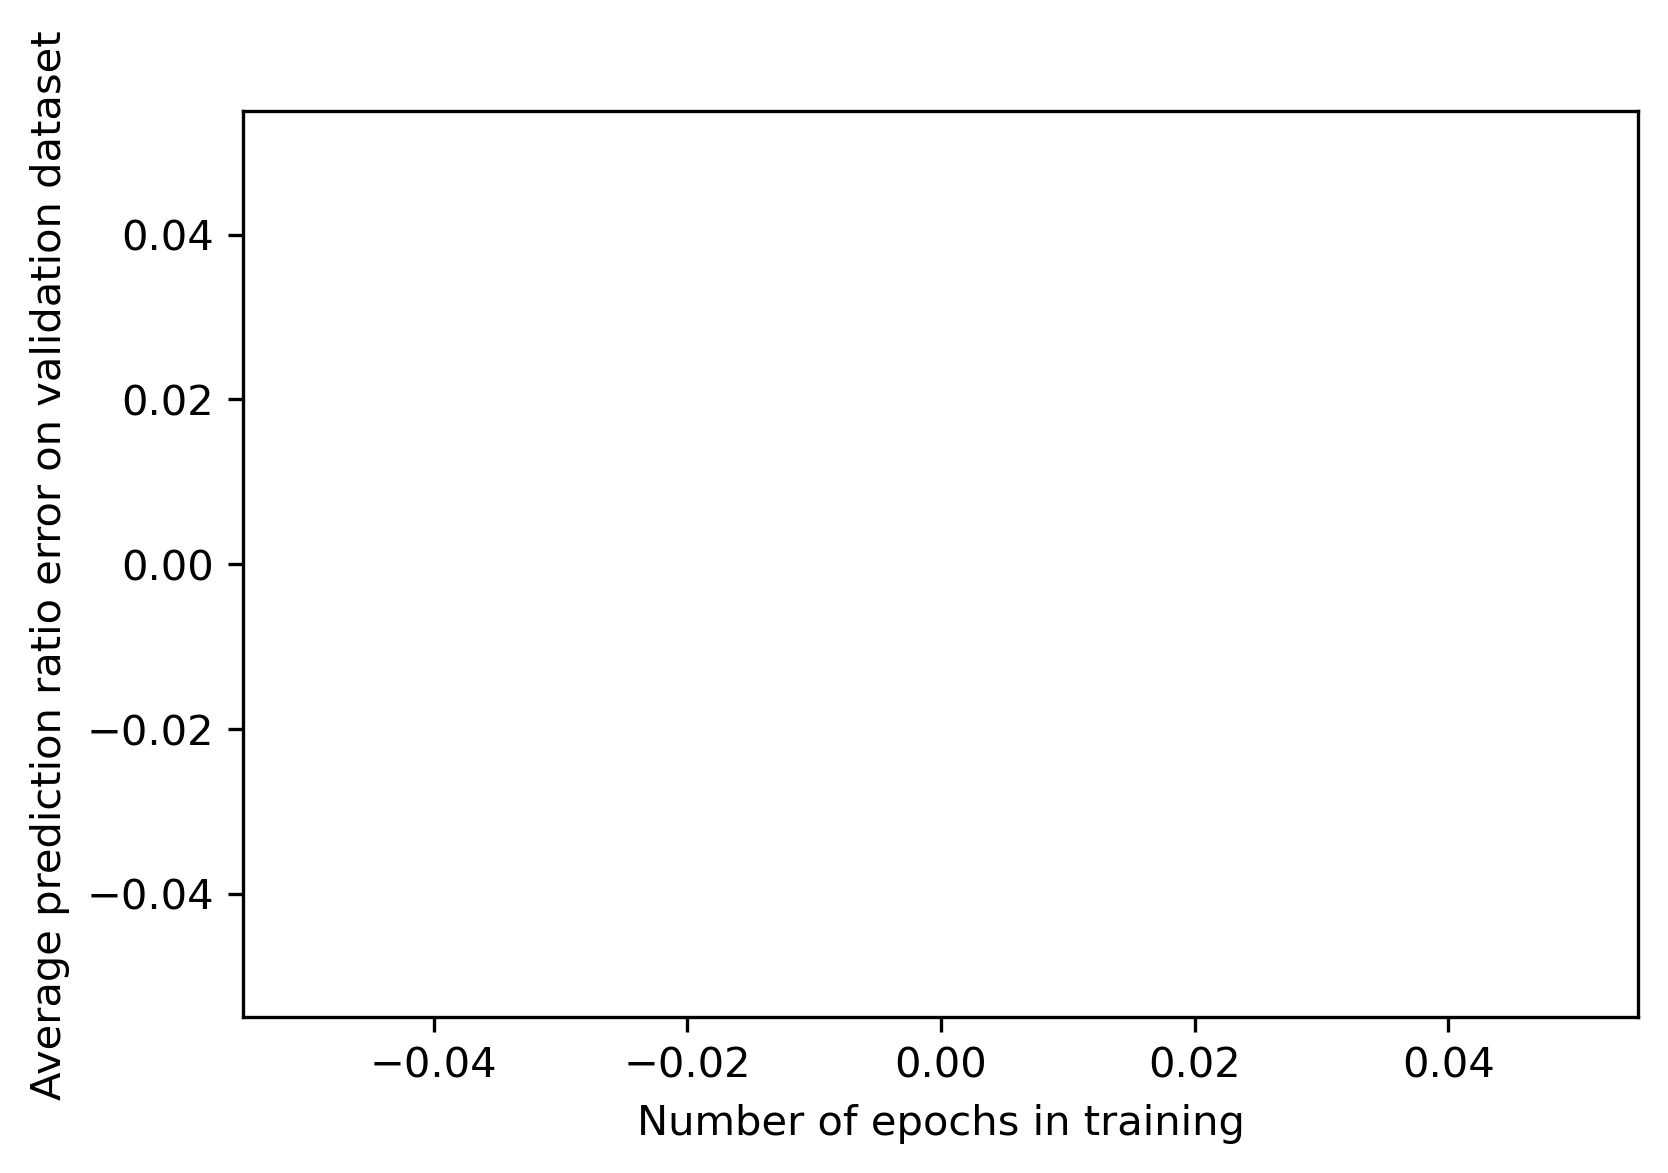

[]
[]
[]
[]
[]


In [15]:
results = [[] for _ in range(5)]
if dataset_name == "large":
    var_epochs = [10, 30, 50, 100, 150, 200]
else:
    var_epochs = [2, 6, 10, 20, 30, 40]
    
if not run_simulations:
    var_epochs = []

    
for var_epoch in var_epochs:
    epochs = var_epoch
    print(epochs)
    outs = stats(depth, hidden_layer_size, skip_gaps, dropout, batch_norms, mixup, max_time = max_time, runs = runs)
    for i in range(len(outs)):
        results[i].append(outs[i])
        
if dataset_name == "large":
    epochs = 100
else:
    epochs = 20
        
plt.xlabel("Number of epochs in training")
plt.ylabel("Average prediction ratio error on validation dataset")
plt.plot(var_epochs, results[0])
plt.fill_between(var_epochs, np.array(results[0]) - np.array(results[2]), np.array(results[0]) + np.array(results[2]), color='b', alpha=.1)
plt.show()
for i in range(len(results)):
    print(results[i])

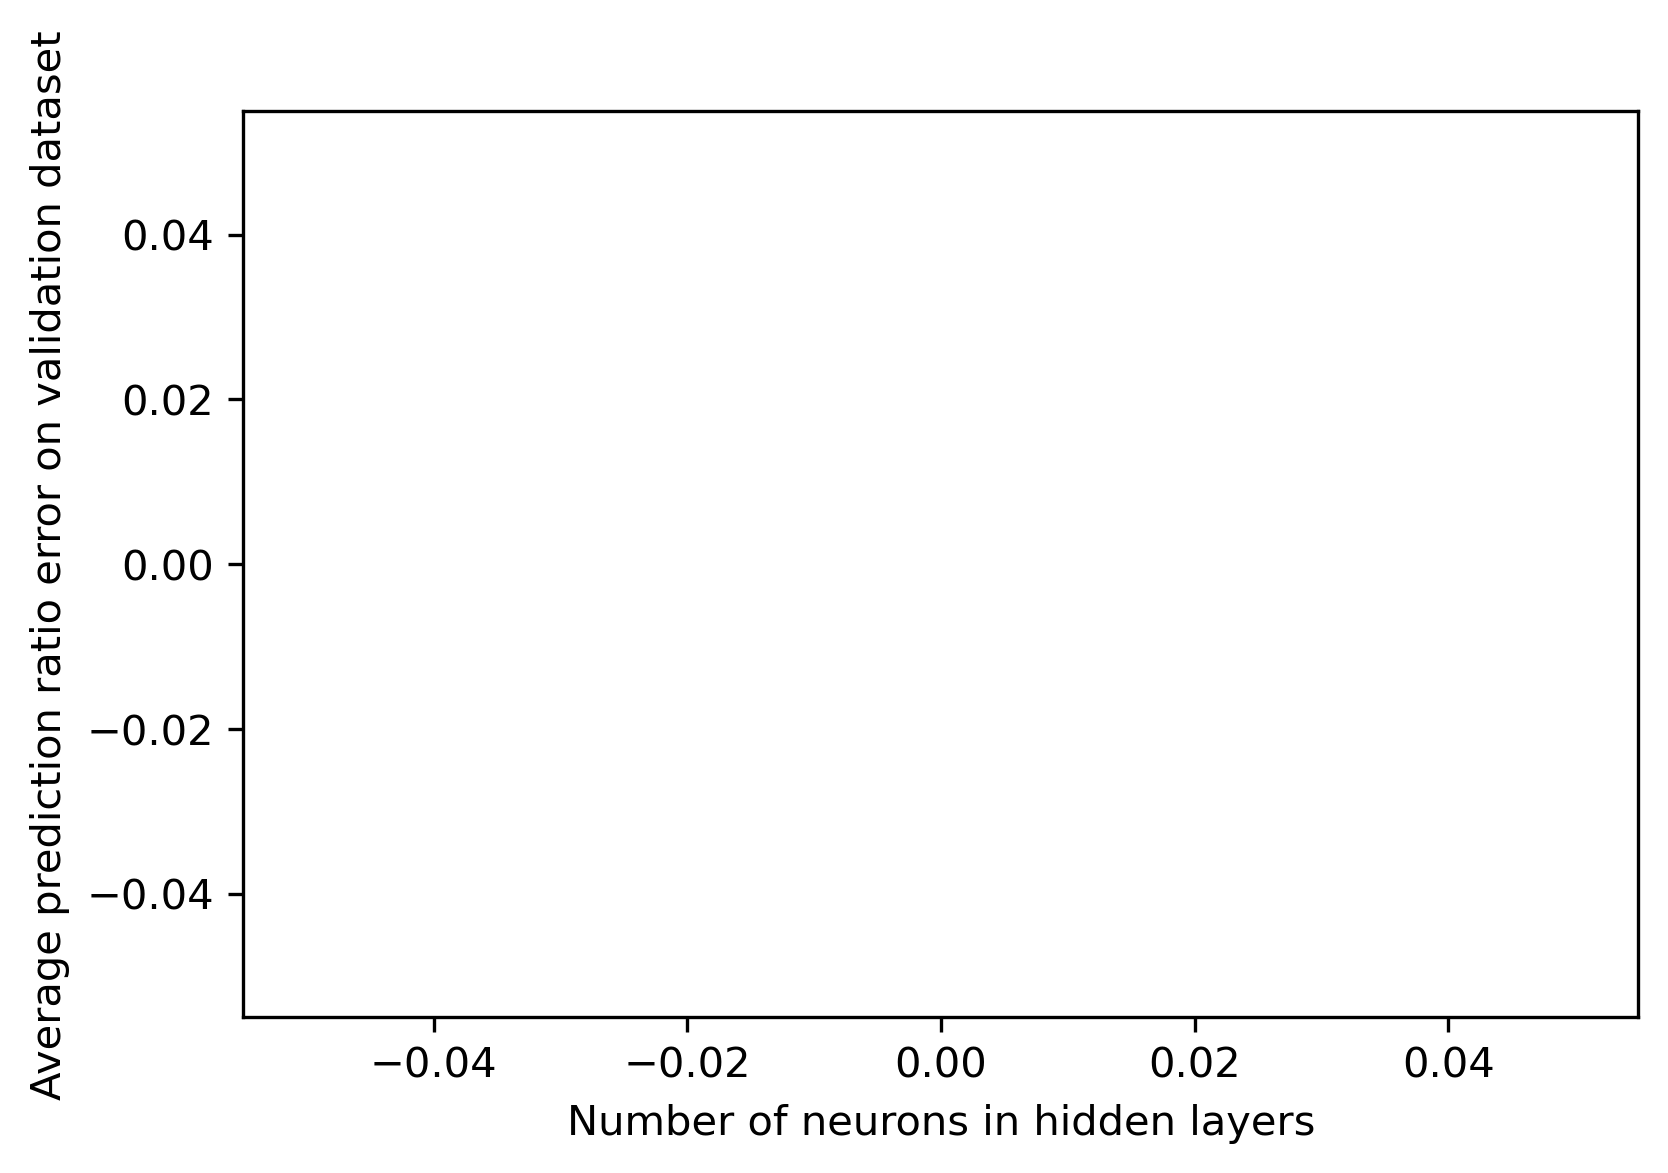

[]
[]
[]
[]
[]


In [16]:
results = [[] for _ in range(5)]
sizes = [5, 10, 20, 40, 80, 160, 320, 640]
if not run_simulations:
    sizes = []

for size in sizes:
    print(size)
    outs = stats(depth, size, skip_gaps, dropout, batch_norms, mixup, max_time = max_time, runs = runs)
    for i in range(len(outs)):
        results[i].append(outs[i])
        
plt.xlabel("Number of neurons in hidden layers")
plt.ylabel("Average prediction ratio error on validation dataset")
plt.plot(sizes, results[0])
plt.fill_between(sizes, np.array(results[0]) - np.array(results[2]), np.array(results[0]) + np.array(results[2]), color='b', alpha=.1)
plt.show()
for i in range(len(results)):
    print(results[i])

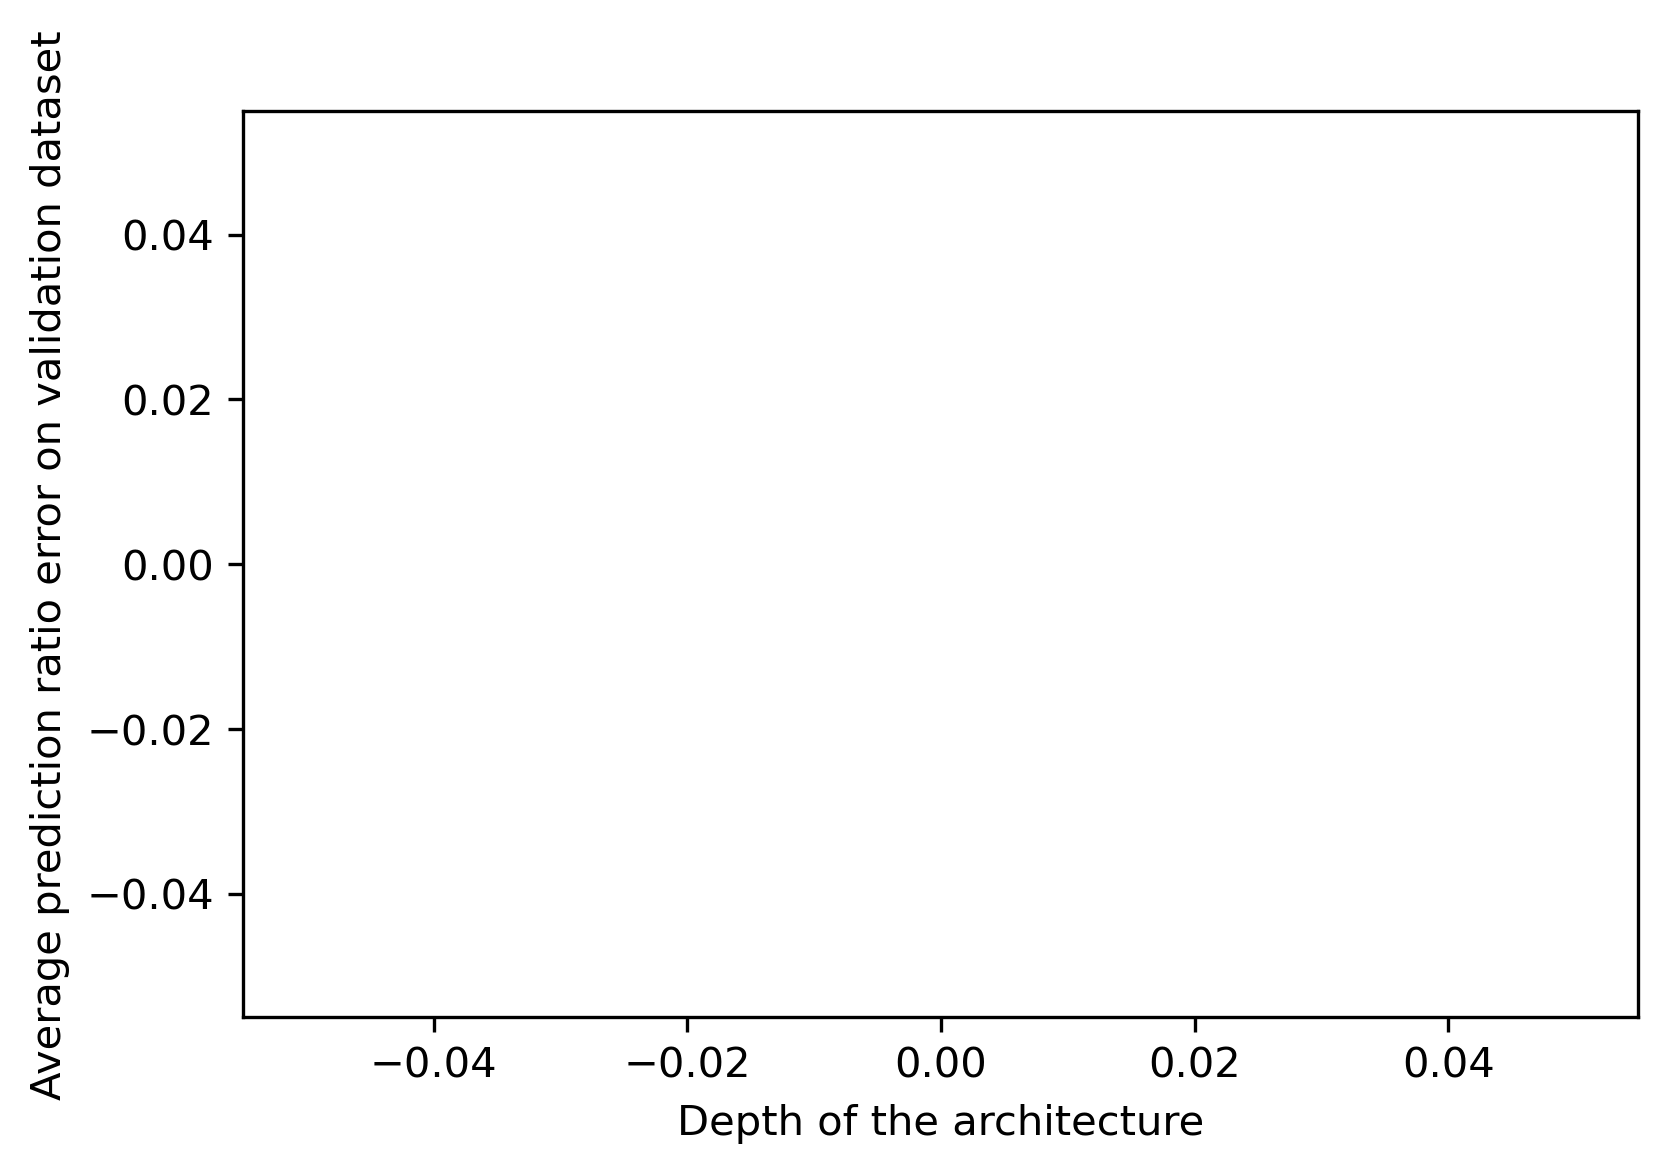

[]
[]
[]
[]
[]


In [17]:
results = [[] for _ in range(5)]
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
if not run_simulations:
    depths = []


for var_depth in depths:
    print(var_depth)
    outs = stats(var_depth, hidden_layer_size, skip_gaps, dropout, batch_norms, mixup, max_time = max_time, runs = runs)
    for i in range(len(outs)):
        results[i].append(outs[i])
        
plt.xlabel("Depth of the architecture")
plt.ylabel("Average prediction ratio error on validation dataset")
plt.plot(depths, results[0])
plt.fill_between(depths, np.array(results[0]) - np.array(results[2]), np.array(results[0]) + np.array(results[2]), color='b', alpha=.1)
plt.show()
for i in range(len(results)):
    print(results[i])

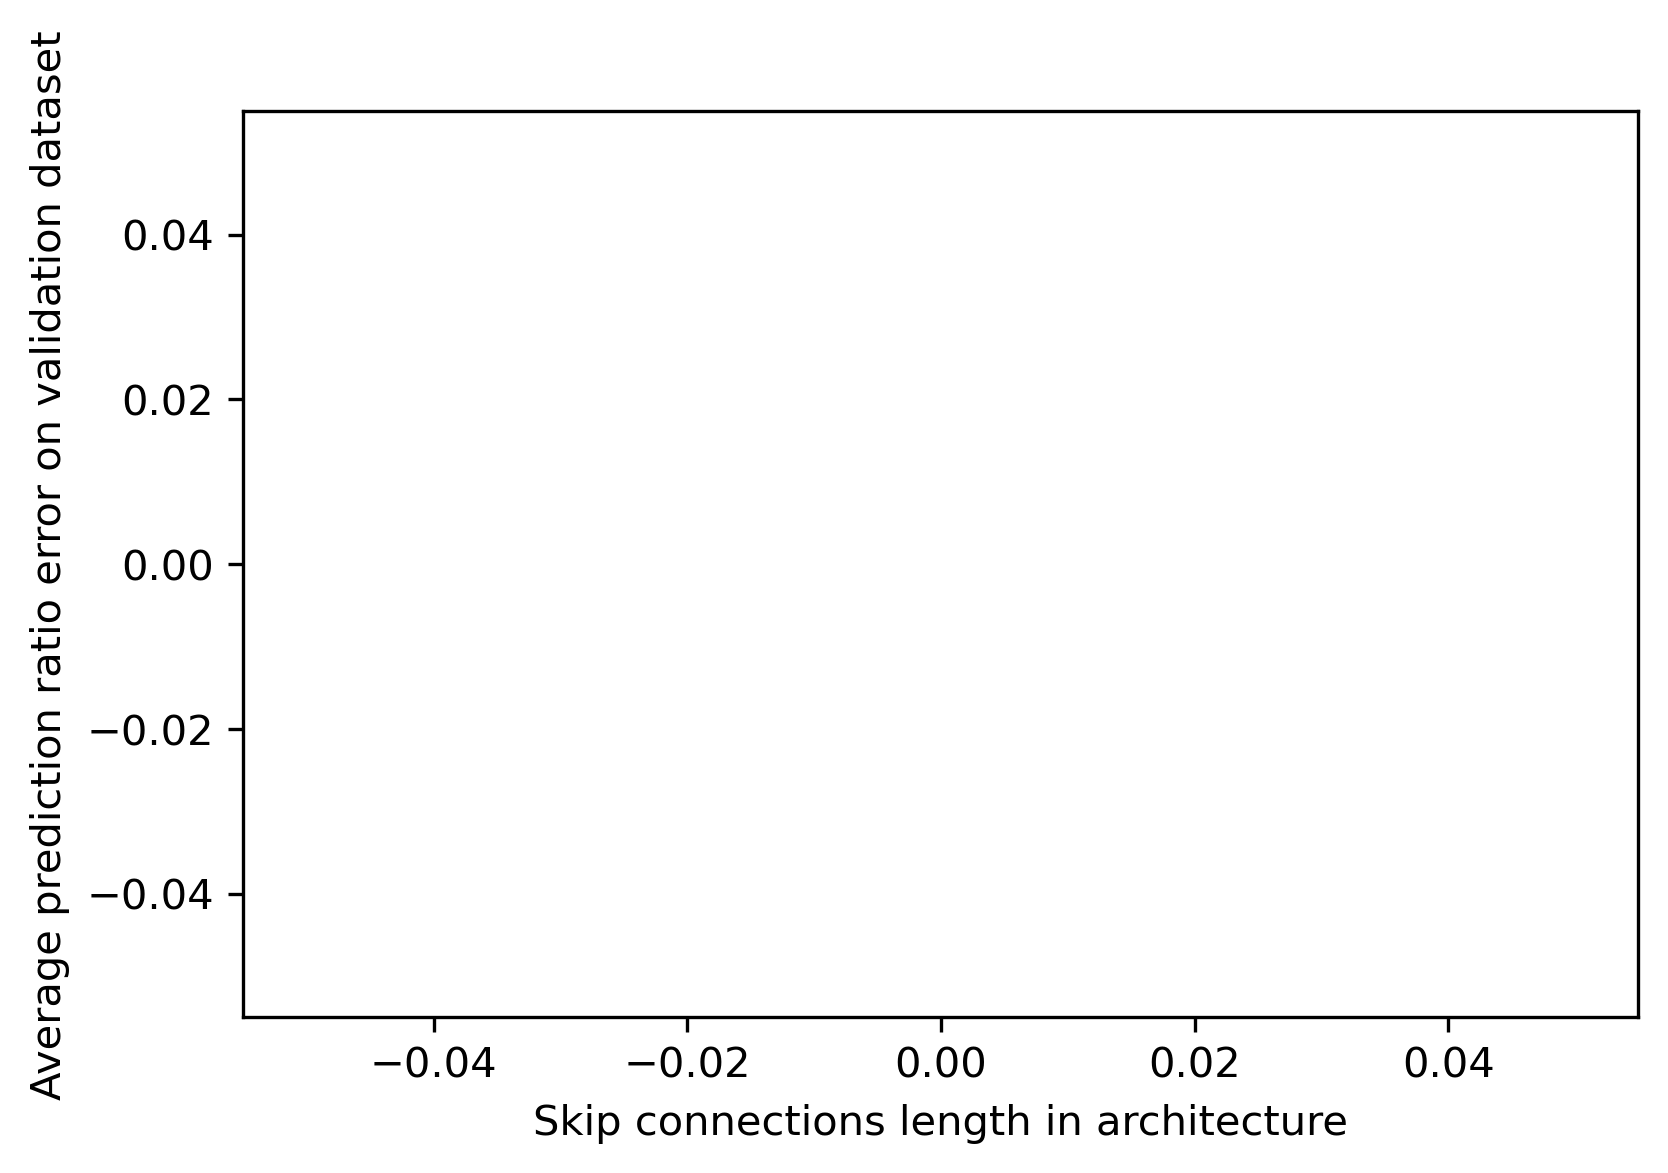

[]
[]
[]
[]
[]


In [18]:
results = [[] for _ in range(5)]
gaps = [2, 3, 4, 5, 6]
if not run_simulations:
    gaps = []
    
for gap in gaps:
    print(gap)
    outs = stats(depth, hidden_layer_size, gap, dropout, batch_norms, mixup, max_time = max_time, runs = runs)
    for i in range(len(outs)):
        results[i].append(outs[i])
        
plt.xlabel("Skip connections length in architecture")
plt.ylabel("Average prediction ratio error on validation dataset")
plt.plot(gaps, results[0])
plt.fill_between(gaps, np.array(results[0]) - np.array(results[2]), np.array(results[0]) + np.array(results[2]), color='b', alpha=.1)
plt.show()
for i in range(len(results)):
    print(results[i])

In [19]:
if run_simulations:
    for do in [True, False]:
        for bn in [False, True]:
            for mu in [False, True]:
                print("dropout: " + str(do) + ", bn: " + str(bn) + ", mixup: " + str(mu), end=" ")
                score = stats(depth, hidden_layer_size, skip_gaps, do, bn, mu, max_time = max_time, runs = runs)
                print(score)


In [20]:
def write_inputs(inputs, method):
    inputs = unstandardize_input(inputs)
    f = open("proposed_fb_" + method + "_" + dataset_name + ".txt", "a")
    for i in range(inputs.shape[0]):
        for j in range(inputs.shape[1]):
            f.write(str(int(inputs[i,j].item())) + " ")
        f.write("\n")
    f.close()

def write_outputs(outputs, method, do_write = True):
    outputs = unstandardize_output(outputs)
    if do_write:
        f = open("proposed_fer_" + method + "_" + dataset_name + ".txt", "a")
        for i in range(outputs.shape[0]):
            f.write(str(outputs[i].item()) + "\n")
        f.close()
    return outputs

def random_search(num_models, max_time, depth, hidden_layer_size, skip_gaps, dropout, bns, mixup):
    models = [Architecture(depth, hidden_layer_size, skip_gaps, dropout = dropout, bns = bns) for _ in range(num_models)]
    print("Training models...")
    for i in range(len(models)):
        train(models[i], epochs, mixup)
    print("Training finished.")
    best_fer = 1000
    start_time = time.time()
    total_tested = 0
    while True:
        inp = torch.ones(1000, new_x_train.shape[1]).to(device)
        for i in range(inp.shape[0]):
            inp[i, torch.randperm(inp.shape[1])[:inp.shape[1] // 2]] = -1
        with torch.no_grad():
            out = torch.cat([model(inp).reshape(-1, 1) for model in models], dim = 1).mean(dim = 0)        
        index = torch.argmin(out)
        if out[index] < best_fer:
            best_fer = out[index]
            write_inputs(inp[index].reshape(1, -1), "random_search")
            output = write_outputs(out[index].reshape(1, -1), "random_search")
            print("new best fer is: {:g}".format(output.item()))
        if time.time() - start_time > max_time:
            break
        total_tested += 1000
        if total_tested % 10000000 == 0:
            print("Total tested is: " + str(total_tested))

In [21]:
def pgd_search(model, lr, iterations):
    global best_fer_dataset
    model.requires_grad = False
    for p in model.parameters():
        p.requires_grad = False
    data = torch.ones(1, new_x_train.shape[1]).to(device)
    for i in range(data.shape[0]):
        data[i, torch.randperm(data.shape[1])[:data.shape[1] // 2]] = -1
        
    data_approx = data.clone()    
    
    data.requires_grad = True   
    data_approx.requires_grad = True
    
    optimizer = torch.optim.SGD([data, data_approx], lr = lr)
    for it in range(iterations):
        optimizer.zero_grad()
        
        with torch.no_grad():
            meds = torch.median(data_approx, dim = 1)[0]
            for i in range(data.shape[0]):
                data[i][torch.where(data_approx[i] <= meds[i])] = -1
                data[i][torch.where(data_approx[i] > meds[i])] = 1
            
        output = model(data)
        
        with torch.no_grad():
            obtained_best_fer = output.item()
        
            if obtained_best_fer < best_fer_dataset:                
                best_fer_dataset = obtained_best_fer
                write_inputs(data, "pgd")
                write_outputs(output, "pgd")
                print(best_fer_dataset, it)
            
        output.backward()
        data_approx.grad = data.grad
        optimizer.step()

In [22]:
if dataset_name == "large":
    epochs = 100
    hidden_layer_size = 640
    depth = 3
    skip_gaps = 3
    dropout = False
    batch_norms = False
    mixup = False
else:
    epochs = 40
    hidden_layer_size = 320
    depth = 5
    skip_gaps = 3
    dropout = False
    batch_norms = False
    mixup = False
    
model = Architecture(depth, hidden_layer_size, skip_gaps, dropout, batch_norms)
train(model, epochs, mixup)
print("model is trained")

model is trained


In [23]:
pgd_trials = 0
for run in range(pgd_trials):    
    pgd_search(model, 0.1, 5000)

In [24]:
random_search_max_time = 0
if random_search_max_time > 0:
    random_search(1, random_search_max_time, depth, hidden_layer_size, skip_gaps, dropout, batch_norms, mixup)